In [1]:
:e ImportQualifiedPost
:e FlexibleContexts
:e BlockArguments
:e TupleSections
:e FlexibleContexts
:e OverloadedStrings
:e LambdaCase

import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Enumerator
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Sampler.Strict

import Control.Monad
import Data.List
import Data.Ord
import Control.Arrow (first)
import Data.Text (pack, Text)
import Numeric.Log
import Control.Arrow (second)

:l ../plotting.hs

# Sampling

Before discussing inference, we should understand how to sample from models. This notebook explains how to do that.

## Discrete distribution
We'll start with a very simple model, namely:

In [2]:
model :: MonadDistribution m => m Bool
model = bernoulli 0.7

To take a sample, do:

In [3]:
sampler model

False

Or with a fixed seed:

In [4]:
sampleIOfixed model

True

To take multiple samples, you could rerun `sampler` many times, but it's somewhat more in the probabilistic programming spirit to instead define a distribution over multiple draws from `model` and then just sample once, as follows:

In [5]:
multipleDraws :: MonadDistribution m => m [Bool]
multipleDraws = replicateM 10 model

draws <- sampler multipleDraws

draws

[False,True,True,True,True,True,False,False,True,True]

We convert a list of samples to an empirical distribution, where `toEmpirical` function returns list of distribution values with share of their occurence in the :

In [6]:
emp = toEmpirical draws :: [(Bool, Double)]

emp

[(True,0.7),(False,0.3)]

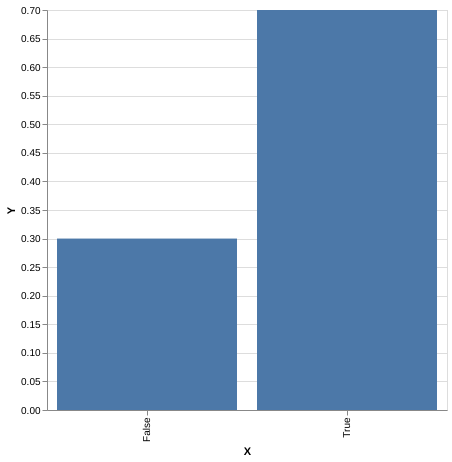

In [7]:
plot $ first (pack . show) <$> emp

In fact, we could lean even further into the spirit of probabilistic programming, and transform `model` into a distribution over plots, and sample from that:

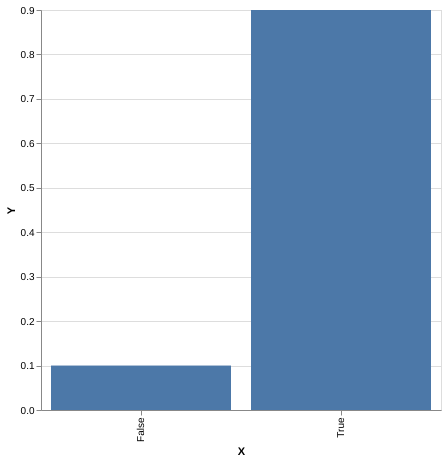

In [8]:
distributionOverPlots :: MonadDistribution m => m VegaLiteLab -- the type of plots
distributionOverPlots = plot . fmap (first (pack . show)) . toEmpirical <$> replicateM 10 model

sampler distributionOverPlots


In [9]:
sampler $ toEmpirical <$> replicateM 10 model
:t toEmpirical <$> replicateM 10 model

[(True,0.7),(False,0.3)]

toEmpirical <$> replicateM 10 model :: forall {f :: * -> *} {b}. (Fractional b, Ord b, MonadDistribution f) => f [(Bool, b)]

## Continuous distributions

Consider normal distribution:

In [10]:
model2 :: MonadDistribution m => m Double
model2 = normal 0 1

Sampling is no different to before:

In [11]:
sampler model2

-4.521959900261888e-2

And as before, to obtain multiple draws:

In [12]:
multipleDraws2 :: MonadDistribution m => m [Double]
multipleDraws2 = replicateM 10 model2

draws2 <- sampler multipleDraws2

draws2

[-0.6216690402229845,-0.47608570111519477,0.4670018245275328,-0.731326261945339,1.8293339635456327,-0.31691850879028954,-0.1522034252473077,-0.4871801689979811,0.4312750347264313,0.6641920998609923]

We'd like to view a histogram of samples, which in the limit of many samples should tend to the PDF of a normal distribution.

Again, we could generate a histogram from a drawn list of samples:

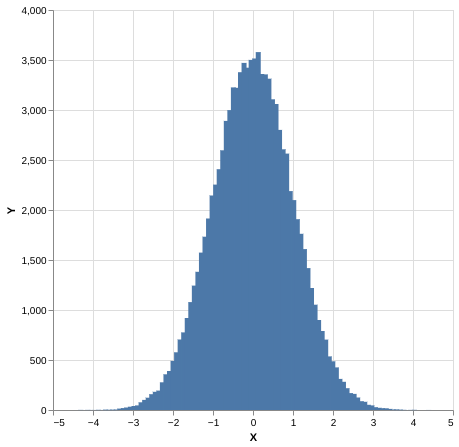

In [13]:
constWeight = 1 :: Log Double

samples <- sampler $  replicateM 100000 ((,constWeight) <$> model2)
plot . histogramToList . histogram 100 $ samples

Note, that the type of histogram is:
```haskell
histogram :: Int -> [(Double, Log Double)] -> Histogram
```
because it is used in more general context for weighted samples (see next chapter).\
That is why we need to introduce a constant weight for our simple example by mapping samples to a pair (value, score) with `(,constWeight) <$> `.

In [14]:
sampler $ replicateM 3 model2


[0.40485488235651435,1.1348389537359198,-1.092972060021726]

but it's nicer to apply a `histogram` function to multiple draws to define a distribution over histograms from which we'll sample.\
In that approach a distribution is composed and transformed first and the sampling is clearly split from the distribution definition.

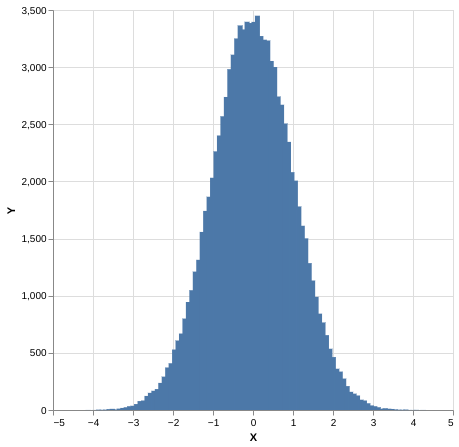

In [15]:
sampler $ plot . histogramToList . histogram 100 <$> replicateM 100000 ((,constWeight) <$>  model2)

Mixture model:

In [16]:
model3 = do
    p <- bernoulli 0.7
    if p then normal 0 1 else normal 3 1

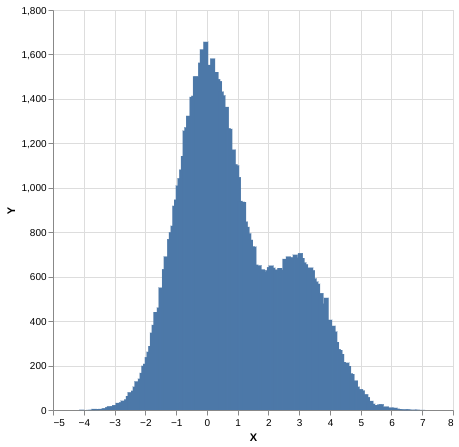

In [17]:
sampler $ 
    plot . histogramToList . histogram 200
    <$> replicateM 100000 (weighted model3)


# Weighted Sampling

For models with factor statements, we cannot just sample. For example, consider a distribution which is conditioned to positive values only:

In [18]:
model4 = do
    p <- bernoulli 0.7
    out <- if p then normal 0 1 else normal 3 1
    condition (out > 0)
    return out


`condition` is a special case of `factor` statement for binary factors.

Here, we use `weighted` to convert `model4` into a distribution over pairs of numbers and their weights. We then sample from that. To view 

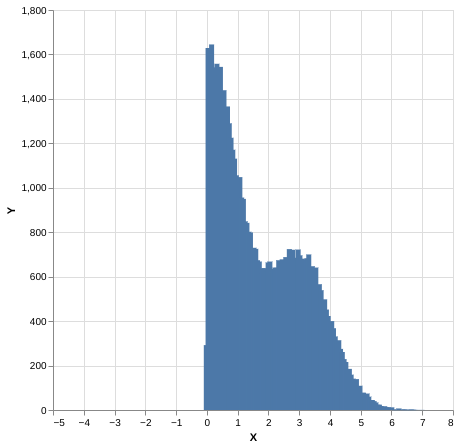

In [19]:
sampler $ 
    plot . histogramToList . histogram 200
    <$> replicateM 100000 (weighted model4)

We could ignore the `condition` statement using `unweighted`, as in:

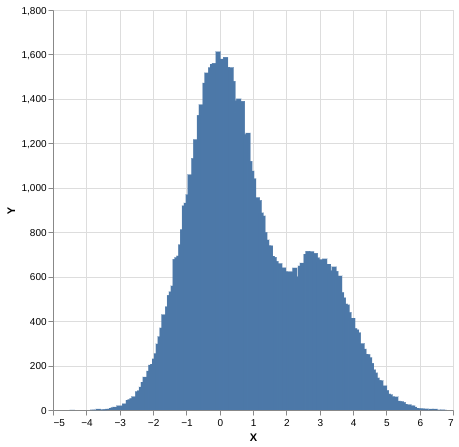

In [20]:
sampler . unweighted $ plot . histogramToList . histogram 200 <$> replicateM 100000 (weighted $ unweighted model4)


But obviously, we'd like to take samples from the posterior. We can do so as follows:

In [21]:
draws4 <- sampler $ replicateM 10 $ weighted model4
draws4

[(4.22455827914325,1.0),(0.906234848690838,1.0),(2.6860029976528135,1.0),(-0.17404924439421926,0.0),(-1.1044111213397145,0.0),(-0.5604681812378783,0.0),(-0.1850630831580971,0.0),(3.354382098966137,1.0),(2.641529507690727,1.0),(0.7142981214125107,1.0)]

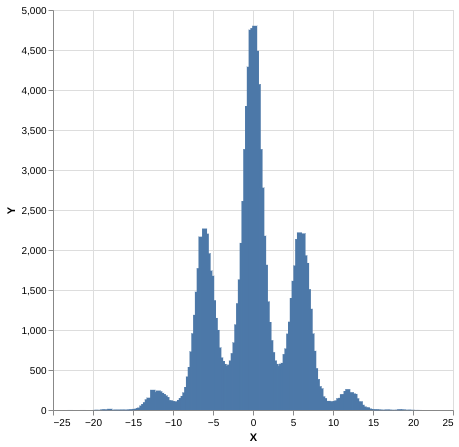

In [22]:
model5 :: MonadMeasure m => m Double
model5 = do
    x <- normal 0 5
    (factor . Exp) (cos x)
    return x

sampler $ 
    plot . histogramToList . histogram 200
    <$> replicateM 100000 (weighted model5)